# Lab 6: Mixture Models + Model order selection

# Work completed by: Mohamed Amine HACHICHA

The goal of this lab session is to study mixture models. In the first part you will code the EM algorithm to estimate the parameters of a GMM given the number of mixed distributions and in the second part you will try different model order selection methods. You will send only one notebook for both parts.

You have to send the filled notebook named **"L4_6_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2020@gmail.com before November 28 at 23:59 and put **"AML-L4-6"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class to implement a multivariate GMM:

In [38]:
from sklearn.cluster import KMeans
import numpy as np
from scipy.stats import multivariate_normal

class my_GMM():
    
    def __init__(self, k):
        '''
        Parameters:
        k: integer
            number of components
        
        Attributes:
        
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        probas_: np.array
            contains the contributions of the gaussians
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k_ = k
        self.mu_ = None
        self.Sigma_ = None
        self.probas_ = None
        self.cond_prob_ = None
        self.labels_ = None
        
    def fit(self, X):
        """ Find the parameters mu_ and Sigma_
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        def compute_condition_prob_matrix(X, mu, Sigma, probas):
            '''Compute the conditional probability matrix 
            shape: (n, K)
            '''
            n = X.shape[0]
            k = len(probas)
            cond_probas = np.zeros((n, k))
            for i in range(n):
                denominator = 0
                for j in range(k):
                    denominator += probas[j] * multivariate_normal.pdf(X[i], mean=mu[j], cov=Sigma[j])
                for j in range(k):
                    cond_probas[i, j] = probas[j] * multivariate_normal.pdf(X[i], mean=mu[j], cov=Sigma[j]) / denominator
            return cond_probas
        
        
        self.mu_ = {}
        self.Sigma_ = {}
        
        # initialize the parameters by applying kmeans
        model = KMeans(n_clusters=self.k_)
        model.fit(X)
        
        for i in range(self.k_):
            mu = model.cluster_centers_[i]
            self.mu_[i] = mu
            
            points = X[model.labels_==i]
            sigma = np.zeros((X.shape[1], X.shape[1]))
            for point in points:
                sigma += np.dot((point-mu).reshape(-1, 1), (point-mu).reshape(1, -1))
            self.Sigma_[i] = sigma / len(points)
        
        # Initialize the cond_probas_ matrix
        self.probas_ = np.ones(self.k_) / self.k_

        
        max_iter = 30
        n = X.shape[0]
        for i in range(max_iter):
            #   Compute conditional probability matrix
            self.cond_prob_ = compute_condition_prob_matrix(X.copy(), self.mu_, self.Sigma_, self.probas_)
            
            #   Update parameters
            self.probas_ = self.cond_prob_.mean(axis=0)
            
            for j in range(self.k_):
                self.mu_[j] = (X * self.cond_prob_[:, j].reshape(-1, 1)).sum(axis=0) / (n * self.probas_[j])
                new_sigma = 0
                mu = self.mu_[j]
                for i in range(n):
                    new_sigma += self.cond_prob_[i, j] * np.dot((X[i]-mu).reshape(-1, 1), (X[i]-mu).reshape(1, -1))
                self.Sigma_[j] = new_sigma / (n * self.probas_[j])
        
        # Update labels_
        self.labels_ = self.cond_prob_.argmax(axis=1)
        return
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        def compute_condition_prob_matrix(X, mu, Sigma, probas):
            '''Compute the conditional probability matrix 
            shape: (n, K)
            '''
            n = X.shape[0]
            k = len(probas)
            cond_probas = np.zeros((n, k))
            for i in range(n):
                denominator = 0
                for j in range(k):
                    denominator += probas[j] * multivariate_normal.pdf(X[i], mean=mu[j], cov=Sigma[j])
                for j in range(k):
                    cond_probas[i, j] = probas[j] * multivariate_normal.pdf(X[i], mean=mu[j], cov=Sigma[j]) / denominator
            return cond_probas
        
        return compute_condition_prob_matrix(X, self.mu_, self.Sigma_, self.probas_).argmax(axis=1)
        
    def compute_proba(self, X):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        def compute_condition_prob_matrix(X, mu, Sigma, probas):
            '''Compute the conditional probability matrix 
            shape: (n, K)
            '''
            n = X.shape[0]
            k = len(probas)
            cond_probas = np.zeros((n, k))
            for i in range(n):
                denominator = 0
                for j in range(k):
                    denominator += probas[j] * multivariate_normal.pdf(X[i], mean=mu[j], cov=Sigma[j])
                for j in range(k):
                    cond_probas[i, j] = probas[j] * multivariate_normal.pdf(X[i], mean=mu[j], cov=Sigma[j]) / denominator
            return cond_probas
        
        return compute_condition_prob_matrix(X, self.mu_, self.Sigma_, self.probas_)

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

In [35]:
import random

# We define our parameters
real_probas = np.array([0.4, 0.3, 0.3])
real_mu = {0: np.array([0, 0]),
          1: np.array([7, 8]),
          2: np.array([-4, -8])}
real_sigma = {0: np.array([[1, 0.2], [0.2, 1.5]]),
             1: np.array([[2, 0.5], [0.5, 1.5]]),
             2: np.array([[2, 0.7], [0.7, 1]])}

# We sample 400 points of this GMM
n_samples = 400
X = []
real_labels = []
for i in range(n_samples):
    p = random.uniform(0,1)
    # Choose the component label with multinomial distribution 
    # and then sample from the corresponding multivariate normal distribution
    if p < real_probas[0]:
        real_labels.append(0)
        X.append(np.random.multivariate_normal(mean=real_mu[0], cov=real_sigma[0]))
    elif p < real_probas[0] + real_probas[1]:
        X.append(np.random.multivariate_normal(mean=real_mu[1], cov=real_sigma[1]))
        real_labels.append(1)
    else:
        X.append(np.random.multivariate_normal(mean=real_mu[2], cov=real_sigma[2]))
        real_labels.append(2)

X = np.array(X)
real_labels = np.array(real_labels)

In [39]:
# Fit a GMM to our simulated data
gmm_0 = my_GMM(k=3)
gmm_0.fit(X=X)

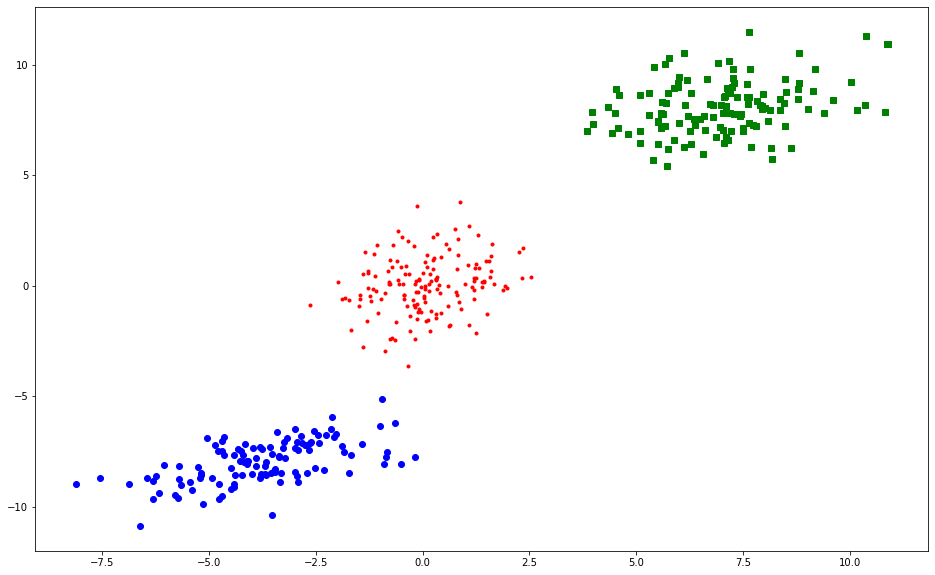

In [193]:
import matplotlib.pyplot as plt
markers = ["." , "," , "o" ]
colors = ['r','g','b']

fig = plt.figure(figsize=(16,10))
n_labels = 3
for real_label in range(n_labels): #for each of the 7 features 
    for predicted_label in range(n_labels):
        marker = markers[real_label]
        color = colors[predicted_label]
        idx = (real_labels == real_label) & (gmm_0.labels_ == predicted_label)
        plt.scatter(X[idx, 0], X[idx, 1] ,marker=marker, color=color)
plt.show()

### Our GMM works well !

### Second Part
 
- Select the number of clusters using the model order selection methods from the lecture (AIC, BIC)

In [51]:
from math import log

def select_AIC(X, K_array):
    n, p = X.shape[0], X.shape[1]
    AIC_list = []
    for K in K_array:
        model = my_GMM(k=K)
        model.fit(X=X)
        n_parameters = K + K*p + K*(p+1)*p/2 # Total number of parameters
        log_lik = 1
        for i in range(n):
            l = 0
            for k in range(K):
                l += model.probas_[k] * multivariate_normal.pdf(X[i], mean=model.mu_[k], cov=model.Sigma_[k])
            log_lik += log(l) # update log-likelihood
        AIC_list.append(log_lik - n_parameters)
    return AIC_list, K_array[AIC_list.index(max(AIC_list))]

The optimal number of components with AIC method is 3


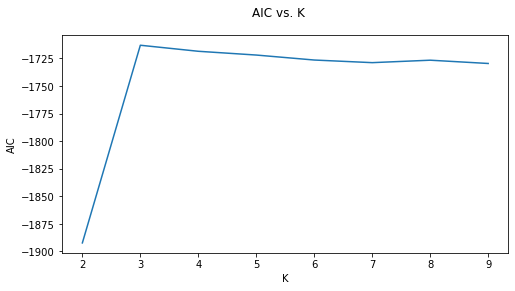

In [61]:
# We try the AIC selection method on our simulated mixture data

K_array = np.array([2, 3, 4, 5, 6, 7, 8, 9])
AIC_List, optimal_K = select_AIC(X, K_array=K_array)

print('The optimal number of components with AIC method is {}'.format(optimal_K))

fig = plt.figure(figsize=(8,4))
plt.plot(K_array, AIC_List)
plt.suptitle('AIC vs. K')
plt.xlabel('K')
plt.ylabel('AIC')
plt.show()

- Select the number of clusters using the model order reduction methods from the lecture (distance, correlation and parameter criteria)

In [194]:
def merge_clusters(model, X, criterion, eps, return_min_distances):
    mu_s = model.mu_.copy()
    Sigma_s = model.Sigma_.copy()
    labels = model.labels_.copy()
    probas = model.probas_.copy()
    
    probas = dict(zip(list(mu_s.keys()), probas))
    
    # Calculate population of each cluster:
    counts = np.unique(labels, return_counts=True)
    populations = dict(zip(counts[0], counts[1]))
    
    if criterion == "distance": 
        
        converged = False
        min_distances = []
        
        while not(converged) and (len(mu_s)>=2):
            min_distance = np.inf
            idx_min = (0, 0)
            cluster_labels = list(mu_s.keys())
            for i in range(len(cluster_labels)):
                for j in range(i+1, len(cluster_labels)):
                    dist_ij = np.linalg.norm(mu_s[cluster_labels[i]]-mu_s[cluster_labels[j]], 2)
                    if dist_ij < min_distance:
                        min_distance = dist_ij
                        idx_min = (i, j)
            min_distances.append(min_distance)
            if min_distance < eps:
                # merge cluster j into cluster i
                cluster_i = cluster_labels[idx_min[0]]
                cluster_j = cluster_labels[idx_min[1]]
                n_i = populations[cluster_i]
                n_j = populations[cluster_j]
                
                new_mu = (n_i * mu_s[cluster_i] + n_j * mu_s[cluster_j]) / (n_i + n_j)
                new_sigma = (n_i * Sigma_s[cluster_i] + n_j * Sigma_s[cluster_j]) / (n_i + n_j)
                
                # Update mu and Sigma
                mu_s[cluster_i] = new_mu
                del mu_s[cluster_j]
                
                Sigma_s[cluster_i] = new_sigma
                del Sigma_s[cluster_j]
                
                # Update labels
                labels[labels==cluster_j] = cluster_i
                
                # Update populations and probas
                populations[cluster_i] = n_i + n_j
                del populations[cluster_j]
                
                probas[cluster_i] += probas[cluster_j]
                del probas[cluster_j]
    
            else:
                converged = True
        if return_min_distances:
            return len(mu_s), min_distances
        else:
            return len(mu_s)
    else:
        raise ValueError("Criterion is not supported")

In [129]:
gmm_1 = my_GMM(k=9)
gmm_1.fit(X)
print('Model is Fitted')

best_K = merge_clusters(model=gmm_1, X=X, criterion='distance', eps=3, return_min_distances=False)

print('The best K corresponding to the chosen epsilon is : {}'.format(best_K))

Model is Fitted
The best K corresponding to the chosen epsilon is : 3


#### Here I arranged the value epsilon to get the real optimal K=3. But what if we really don't know K? What epsilon do we chose?
#### We use an elbow method, consisting of taking   $\epsilon = +\infty$. 
#### This means that we merge all the clusters step by step. We keep track of the minimum distance at each step before merging clusters. The optimal value for K can be deduced when there's a jump in this minimum distance.
#### Here we show an example on our GMM

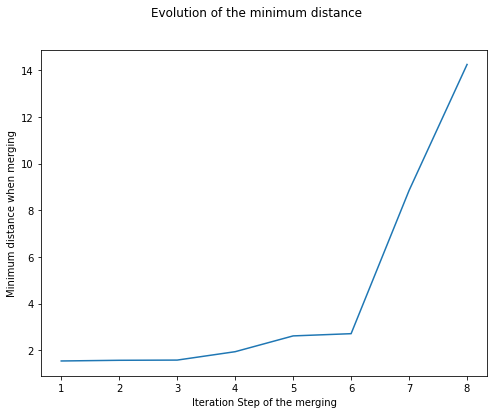

In [130]:
best_K, min_distances = merge_clusters(model=gmm_1, X=X, criterion='distance', eps=np.inf, return_min_distances=True)
fig = plt.figure(figsize=(8,6))
plt.plot(range(1,9), min_distances)

plt.xlabel("Iteration Step of the merging")
plt.ylabel("Minimum distance when merging")
plt.suptitle("Evolution of the minimum distance")
plt.show()

#### Here we observe a jump of the minimum distance after step 6, i.e after 6 merging operations.
#### So we must merge 6 clusters out of 9, thus the optimal K should be indeed 3 = 9 - 6

Do these two methods (order selection and reduction) agree on the final number of clusters for the two given datasets (data-MM-i.csv)? Does it make sense?

Compare the results and the computational time. Try to visually validate your results.

Comment. 

In [142]:
import pandas as pd

data_1 = pd.read_csv("data_MM_1.csv").values
data_2 = pd.read_csv("data_MM_2.csv").values

K_array = np.array([2, 3, 4, 6, 8])
AIC_List, optimal_K = select_AIC(data_1, K_array=K_array)
print('For the dataset 1 :')
print('The optimal number of components with AIC method is {}'.format(optimal_K))

gmm_data_1 = my_GMM(k=12)
gmm_data_1.fit(data_1)
best_K = merge_clusters(model=gmm_data_1, X=data_1, criterion='distance', eps=2, return_min_distances=False)
print('The optimal number of components with merging method is {}'.format(best_K))

For the dataset 1 :
The optimal number of components with AIC method is 3
The optimal number of components with merging method is 2


In [143]:
AIC_List, optimal_K = select_AIC(data_2, K_array=K_array)
print('For the dataset 2 :')
print('The optimal number of components with AIC method is {}'.format(optimal_K))

gmm_data_2 = my_GMM(k=12)
gmm_data_2.fit(data_2)
best_K = merge_clusters(model=gmm_data_1, X=data_1, criterion='distance', eps=2, return_min_distances=False)
print('The optimal number of components with merging method is {}'.format(best_K))

For the dataset 2 :
The optimal number of components with AIC method is 4
The optimal number of components with merging method is 2


##### It's clear that the order selection methods don't agree on the optimal number of components. This does make sense especially because the value for epsilon was arbitrary and changing it will change the number of clusters.

##### For computation time, AIC takes much more time because it fits the GMM model as many K's as we want to test while the merging method only does it once.

#### We try our elbow method on dataset 2.

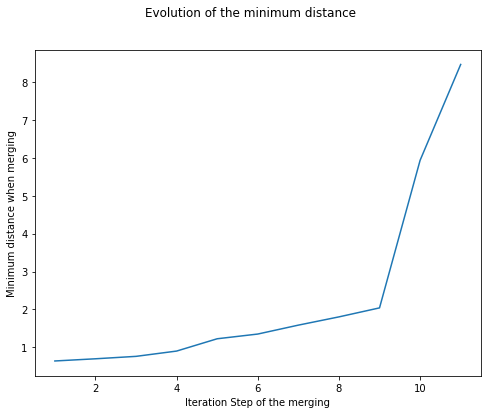

In [145]:
best_K, min_distances = merge_clusters(model=gmm_data_2, X=data_2, criterion='distance', eps=np.inf, return_min_distances=True)
fig = plt.figure(figsize=(8,6))
plt.plot(range(1,12), min_distances)

plt.xlabel("Iteration Step of the merging")
plt.ylabel("Minimum distance when merging")
plt.suptitle("Evolution of the minimum distance")
plt.show()

#### We obviously notice a jump after the 9th iteration so I would say that K=3=12-9 is the optimal number of clusters.

## Application

You are going to work with the following data:

shape: (1797, 64)


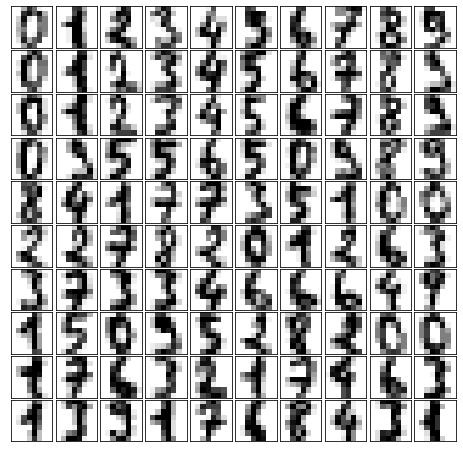

In [146]:
from sklearn.datasets import load_digits
digits = load_digits()
print("shape:", digits.data.shape)

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Model your data with your GMM class using a model order selection method to produce new synthetic handwritten numbers. Explain why you used that model selection method in this case. Finally, sample from every class and visualize to get an idea of what each cluster corresponds to. You should use PCA to reduce the dimension as GMM doesn't perform well in high-dimensional contexts. 

#### Due to the high number of dimensions I can't really tell which order of magnitude the optimal number of clusters is.
#### It's thus very difficult to choose an appropriate epsilon for the distance merging method
#### On the other hand, I can't tell if AIC will have a good performance. The penalization term is kind of arbitrary. Same for BIC
#### That's why I see that the safest and the most visual way to choose the model order is our elbow method that we explained (keeping track of min_distances when merging all clusters and take K such there's a jump in the graph, see above)

In [163]:
# We use PCA with enough components to explain 70% of the variance

from sklearn.decomposition import PCA

pca_model = PCA(n_components=0.7)
pca_model.fit(digits.data)
digits_data_hat = pca_model.transform(digits.data)
print("New shape:", digits_data_hat.shape)

New shape: (1797, 9)


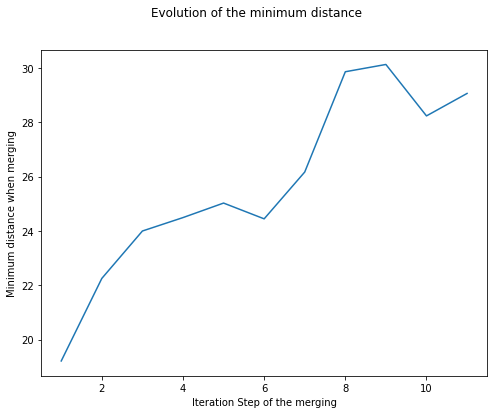

In [165]:
# Fit the GMM model

gmm_digits = my_GMM(k=12)
gmm_digits.fit(digits_data_hat)

best_K, min_distances = merge_clusters(model=gmm_digits, X=digits_data_hat, criterion='distance', eps=np.inf, return_min_distances=True)

fig = plt.figure(figsize=(8,6))
plt.plot(range(1, 12), min_distances)

plt.xlabel("Iteration Step of the merging")
plt.ylabel("Minimum distance when merging")
plt.suptitle("Evolution of the minimum distance")
plt.show()

#### As I thought, the minimum distance does not necessarily increase at each step.
#### We notice a 'big' jump after the 7th step so I the optimal number of clusters is 12 - 7 = 5
### We train a GMM model with K=5

In [167]:
# Fit The GMM model
gmm_digits_opti = my_GMM(k=5)
gmm_digits_opti.fit(digits_data_hat)

#### We inspect cluster 0

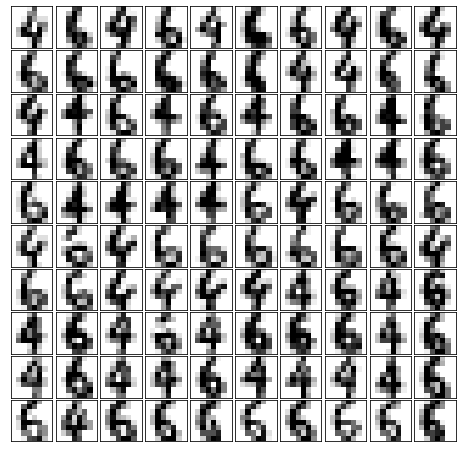

In [168]:
cluster_0_points = digits.data[gmm_digits_opti.labels_==0]

plot_digits(cluster_0_points)

#### Cluster 0 contains apparently sixes and fours
#### We inspect cluster 1

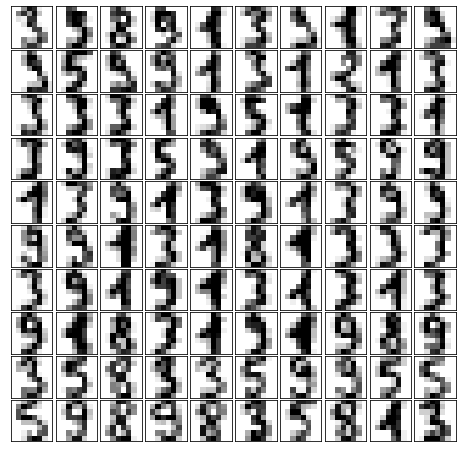

In [171]:
cluster_1_points = digits.data[gmm_digits_opti.labels_==1]

plot_digits(cluster_1_points)

#### Mainly 1's , 3's, 8's and 9's

#### We can do the same for the other clusters.

### Now we simulate new handwritten numbers using our fitted gaussian mixture

In [179]:
# We take 100 samples of our multinomial distribution
# n_samples[i] is the number of times i was sampled
n_samples = np.random.multinomial(100, gmm_digits_opti.probas_)
print(n_samples)

[20 37 22 13  8]


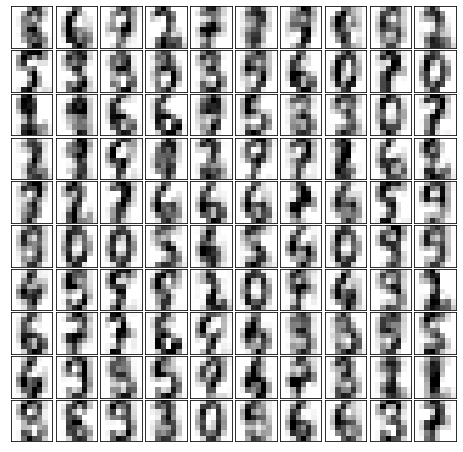

In [192]:
# Simulate 100 new observations
new_numbers = []
for cluster in range(len(gmm_digits_opti.mu_)):
    for i in range(n_samples[cluster]):
        new_numbers.append(np.random.multivariate_normal(mean=gmm_digits_opti.mu_[cluster], cov=gmm_digits_opti.Sigma_[cluster]))
new_numbers = np.array(new_numbers)

# Shuffle new data
from sklearn.utils import shuffle
new_numbers = shuffle(new_numbers)

# Get the inverse PCA transform
new_numbers = pca_model.inverse_transform(new_numbers)

# Plot the new handwritten numbers
plot_digits(new_numbers)

#### For the majority of these images we can easily recognize the written numbers in this generated data
#### We have satisfying results even though we used PCA to reduce dimension